<a href="https://colab.research.google.com/github/tianrengao/Cropping-Script/blob/master/Bonpo_A_khrid_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# import packages and set directory



In [0]:
# acqure the authorization of the google drive, so that we could read from it and save cropped images to it
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Kurt's/Tibetan-Cropping/Bonpo A Khrid Texts (1)") #Change the path to the directory that contains all code and data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Create a diretory to save cropped images
!mkdir  ../../Tibetan-Cropped/Bonpo_A_khrid_Texts
# Create list.txt that contains the list of images to be cropped
!touch list.txt
!ls *.jpg > list.txt

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.cluster.vq import whiten
import cv2 as cv

## Input your image information

In [0]:
# output path
path = "../../Tibetan-Cropped/Bonpo_A_khrid_Texts"
image_list = [] # all the images to be cropped
failed_list = [] # if any cropping fails, add it to failed_list for later cropping
# add all the cropping images to the image_list
with open("list.txt","r") as f:
  for image_name in f:
    name = image_name[:-1]
    image_list.append(name)

image_list = sorted(image_list)
print(image_list)


# hyperparameters
threshold = 1.5
rows = 30
tol = 150 # the cropped image should has height larger than tol, 
          # otherwise, we decline this cropping and move on to the next cropping
mean_height = 550


  # img = cv.imread(image_name)
  # # dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)
  # im = Image.fromarray(img)
  # print(im.size)

['Copy of image00001.jpg', 'Copy of image00002.jpg', 'image00003.jpg', 'image00004.jpg', 'image00005.jpg', 'image00006.jpg', 'image000067.jpg', 'image000068.jpg', 'image00007.jpg', 'image00008.jpg', 'image00009.jpg', 'image00010.jpg', 'image00011.jpg', 'image00012.jpg', 'image00013.jpg', 'image00014.jpg', 'image00015.jpg', 'image00016.jpg', 'image00017.jpg', 'image00018.jpg', 'image00019.jpg', 'image00020.jpg', 'image00021.jpg', 'image00022.jpg', 'image00023.jpg', 'image00024.jpg', 'image00025.jpg', 'image00026.jpg', 'image00027.jpg', 'image00028.jpg', 'image00029.jpg', 'image00030.jpg', 'image00031.jpg', 'image00032.jpg', 'image00033.jpg', 'image00034.jpg', 'image00035.jpg', 'image00036.jpg', 'image00037.jpg', 'image00038.jpg', 'image00039.jpg', 'image00040.jpg', 'image00041.jpg', 'image00042.jpg', 'image00043.jpg', 'image00044.jpg', 'image00045.jpg', 'image00046.jpg', 'image00047.jpg', 'image00048.jpg', 'image00049.jpg', 'image00050.jpg', 'image00051.jpg', 'image00052.jpg', 'image000

## crop funcion

In [0]:
def cut_image(im, bound, image_name, image_index):
  # crop and print the cropped image
  print(bound)
  new_image = im.crop(bound)
  plt.imshow(new_image)
  plt.title("cut")
  plt.show()
  # save the image
  try:
    if not os.path.exists(path):
      os.mkdir(path)
      print("Created directory", path)
    output_path = os.path.join(path, image_name+"-%s.jpg" % image_index)
    new_image.save(output_path)
    print("Saved Image as", output_path, "!!!")
    return True
  except:
    if image_name not in failed_list:
      failed_list.append(image_name)
    print("ERROR: check your path")
    return False

def find_bound(image, img):
  bound_list = []
  height = len(image) 
  width = len(image[0]) 
  # border of next cutting
  left, upper, right, lower = 0, 0, width, 0 
  start = False # This indicates if we have started a new cropping. 

  # Compute the mean of each row
  mean_list = []
  plt.imshow(image)
  plt.title("before")
  plt.show()
  img_1 = img.crop((200, 0, width-200, height)) 
  img_1 = np.array(img_1)

  thresh_num_list = {}
  thresh_total_list = {}
  for i in range(len(image)):
    mean_temp = 255 - np.mean(img_1[i][0:-20], axis=0)
    mean_list.append(mean_temp)
    if np.logical_and(1 < mean_temp, mean_temp < 5):
      if int(mean_temp) not in thresh_num_list:
        thresh_num_list[int(mean_temp)] = 1
        thresh_total_list[int(mean_temp)] = mean_temp
      else: 
        thresh_num_list[int(mean_temp)] += 1
        thresh_total_list[int(mean_temp)] += mean_temp

  print(thresh_num_list)
  mean_key = min(thresh_num_list, key = thresh_num_list.get) 
  threshold = thresh_total_list[mean_key] / thresh_num_list[mean_key]
  print("threshold", threshold)

  # mean_avg = np.mean(mean_list)
  # mean_std = np.std(mean_list)
  # print(mean_avg, mean_std)
  
  # Computer the average of i-th to (i + rows)-th rows
  # if the average is greater than the threshold, then they are characters; otherwise, white space
  for i in range(len(image))[rows:-rows]:
    avg = np.mean(mean_list[i-rows:i+rows]) # compute the average of rows
    # print(i, avg)
    if avg > threshold and not start:
      # We find characters, so we start a new cutting here
      # initalize the upper and lower, and set start to True
      upper, lower = i, i
      start = True
    elif (avg <= threshold or i + rows == height - 1) and start:
      # If we find a white space, we crop the image. If we reach the bottom of the image, we also crop the image.
      # Cut the image using left, upper, right and lower, and also set the start to False
      start = False
      if lower - upper < tol or lower < 10:  
        continue
      bound = [left, upper, right, lower]
      print(bound)
      bound_list.append(bound)
    elif avg > threshold and start:
      # We find characters, and the cropping has started, then we increase the lower, we move to the next row
      lower += 1
  # TODO: compute mean and replace 50.0 
  return adjust_bound(bound_list, height)

def adjust_bound(bound_list, height):
  if len(bound_list) <= 1:
    return bound_list

  border_total = 0
  num = 0
  for i in range(len(bound_list) - 1):
    diff = bound_list[i + 1][1] - bound_list[i][3]
    if diff < 150:
      border_total += diff
      num += 1
  if num > 0:
    border = border_total / num
  else:
    border = 100.0

  border = border * 2 / 3

  for i in range(len(bound_list) - 1):
    prev = bound_list[i]
    curr = bound_list[i + 1]
    prev[3] = prev[3] + border
    curr[1] = curr[1] - border
  bound_list[-1][3] = min(bound_list[-1][3] + border, float(height - 1))
  
  if bound_list[0] !=0 and (bound_list[0][3] - bound_list[0][1]) < mean_height:
    bound_list[0][1] -= (mean_height - (bound_list[0][3] - bound_list[0][1]))
    bound_list[0][1] = max(0, bound_list[0][1])

  return bound_list

def crop(im, image_name):
  # check input
  print("Processing", image_name)
  if im == None:
    print("ERROR: image cannot be None")
    return
  image_index = 0 

  # preprocessing of input images
  image = np.array(im)
  whiten(image)
  # find the bound of each piece
  bound_list = find_bound(image, im)
  # cut and save
  for bound in bound_list:
    if cut_image(im, bound, image_name, image_index):
      image_index += 1
    
  # fail detect: if an image is cut into less than 3 images,
  # we think something went wrong with the cropping,
  # this condition could be changed according to your demand
  if image_index < 3 and image_name not in failed_list:
    print(image_name, "Failed")
    failed_list.append(image_name)

In [0]:
# for all images in the image list, call crop()
# image_list = ["image00072 .jpg"]
for image_name in image_list:
  print(image_name)
  im = Image.open(image_name)
  print(im.size)
  crop(im, image_name[:-4])

In [0]:
print(failed_list)

['Copy of image00002', 'image00003', 'image00004', 'image00071', 'image00074', 'image00076', 'image00121']


00069 .jpg
(3492, 2679)
Processing image00069 


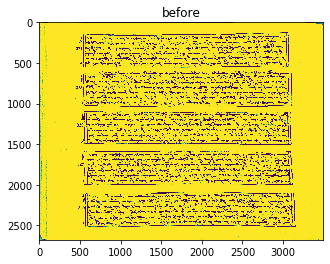

{3: 4, 1: 8, 2: 4, 4: 1}
threshold 4.916666666666657
[0, 128, 3492, 562]
[0, 599, 3492, 1049]
[0, 1096, 3492, 1512]
[0, 1581, 3492, 2007]
[0, 2087, 3492, 2523]
[0, 50.83333333333337, 3492, 600.8333333333334]


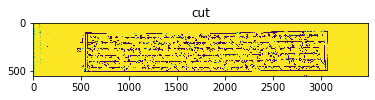

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00069 -0.jpg !!!
[0, 560.1666666666666, 3492, 1087.8333333333333]


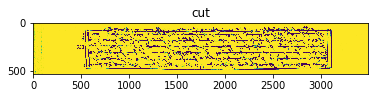

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00069 -1.jpg !!!
[0, 1057.1666666666667, 3492, 1550.8333333333333]


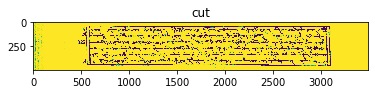

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00069 -2.jpg !!!
[0, 1542.1666666666667, 3492, 2045.8333333333333]


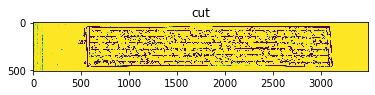

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00069 -3.jpg !!!
[0, 2048.1666666666665, 3492, 2561.8333333333335]


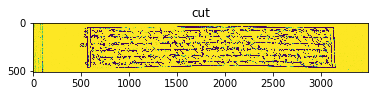

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00069 -4.jpg !!!
00071.jpg
(3547, 2596)
Processing image00071


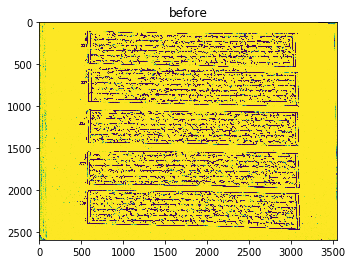

{3: 4, 2: 7, 1: 15, 4: 1}
threshold 4.391109689798526
[0, 105, 3547, 538]
[0, 545, 3547, 1006]
[0, 1041, 3547, 1478]
[0, 1534, 3547, 1982]
[0, 1998, 3547, 2473]
[0, 7.0, 3547, 557.0]


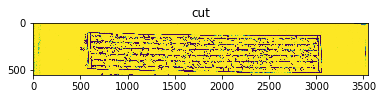

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00071-0.jpg !!!
[0, 526.0, 3547, 1025.0]


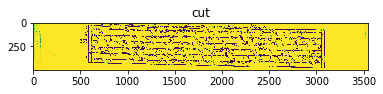

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00071-1.jpg !!!
[0, 1022.0, 3547, 1497.0]


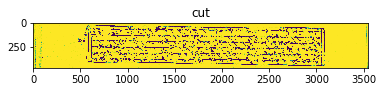

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00071-2.jpg !!!
[0, 1515.0, 3547, 2001.0]


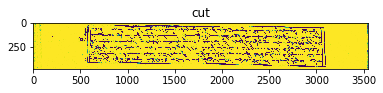

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00071-3.jpg !!!
[0, 1979.0, 3547, 2492.0]


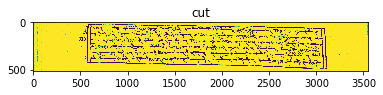

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00071-4.jpg !!!
00072 .jpg
(3643, 2608)
Processing image00072 


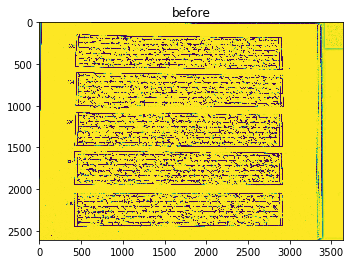

{3: 6, 4: 5, 1: 411, 2: 55}
threshold 4.261123177164132
[0, 144, 3643, 572]
[0, 600, 3643, 1036]
[0, 1079, 3643, 1497]
[0, 1539, 3643, 1957]
[0, 2038, 3643, 2451]
[0, 54.33333333333337, 3643, 604.3333333333334]


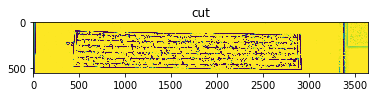

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00072 -0.jpg !!!
[0, 567.6666666666666, 3643, 1068.3333333333333]


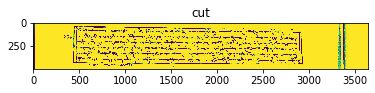

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00072 -1.jpg !!!
[0, 1046.6666666666667, 3643, 1529.3333333333333]


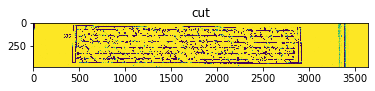

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00072 -2.jpg !!!
[0, 1506.6666666666667, 3643, 1989.3333333333333]


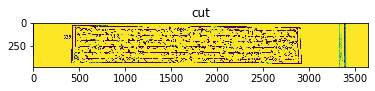

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00072 -3.jpg !!!
[0, 2005.6666666666667, 3643, 2483.3333333333335]


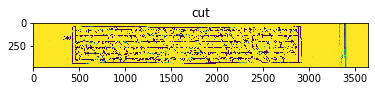

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00072 -4.jpg !!!
00073.jpg
(3513, 2640)
Processing image00073


/usr/local/lib/python3.6/dist-packages/scipy/cluster/vq.py:139: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


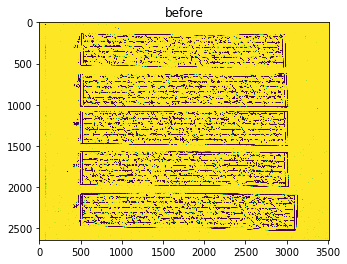

{1: 15, 3: 4, 2: 5, 4: 1}
threshold 4.623019721952801
[0, 138, 3513, 555]
[0, 621, 3513, 1038]
[0, 1072, 3513, 1504]
[0, 1564, 3513, 2003]
[0, 2067, 3513, 2529]
[0, 42.33333333333337, 3513, 592.3333333333334]


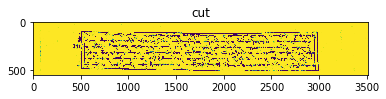

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00073-0.jpg !!!
[0, 583.6666666666666, 3513, 1075.3333333333333]


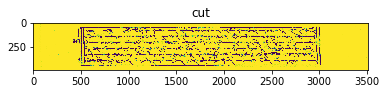

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00073-1.jpg !!!
[0, 1034.6666666666667, 3513, 1541.3333333333333]


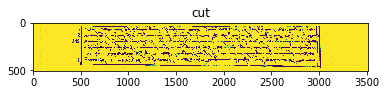

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00073-2.jpg !!!
[0, 1526.6666666666667, 3513, 2040.3333333333333]


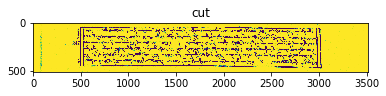

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00073-3.jpg !!!
[0, 2029.6666666666667, 3513, 2566.3333333333335]


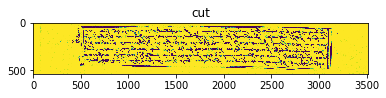

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00073-4.jpg !!!
00074.jpg
(3413, 2606)
Processing image00074


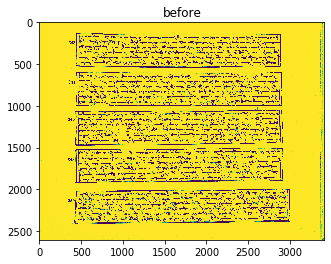

{3: 3, 2: 2, 1: 5, 4: 3}
threshold 2.7086535248914174
[0, 128, 3413, 549]
[0, 594, 3413, 1012]
[0, 1049, 3413, 1480]
[0, 1501, 3413, 1924]
[0, 1992, 3413, 2420]
[0, 27.5, 3413, 577.5]


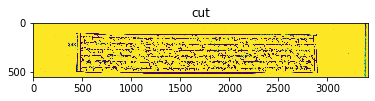

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00074-0.jpg !!!
[0, 565.5, 3413, 1040.5]


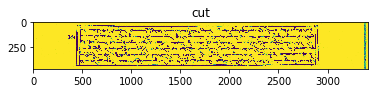

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00074-1.jpg !!!
[0, 1020.5, 3413, 1508.5]


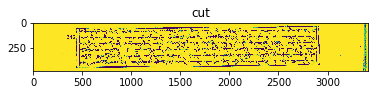

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00074-2.jpg !!!
[0, 1472.5, 3413, 1952.5]


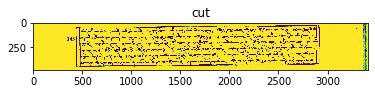

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00074-3.jpg !!!
[0, 1963.5, 3413, 2448.5]


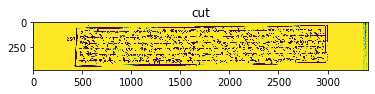

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00074-4.jpg !!!
00076.jpg
(3552, 2607)
Processing image00076


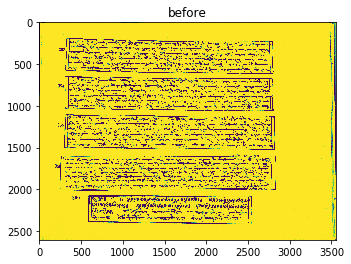

{2: 5, 3: 5, 4: 8, 1: 8}
threshold 2.485696040868453
[0, 191, 3552, 623]
[0, 647, 3552, 1066]
[0, 1103, 3552, 1530]
[0, 1590, 3552, 2023]
[0, 2069, 3552, 2419]
[0, 100.83333333333337, 3552, 650.8333333333334]


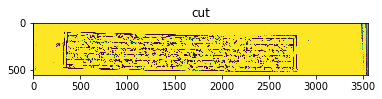

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00076-0.jpg !!!
[0, 619.1666666666666, 3552, 1093.8333333333333]


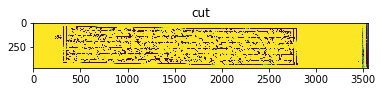

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00076-1.jpg !!!
[0, 1075.1666666666667, 3552, 1557.8333333333333]


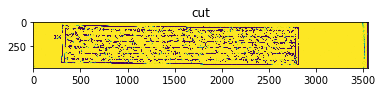

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00076-2.jpg !!!
[0, 1562.1666666666667, 3552, 2050.8333333333335]


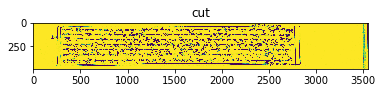

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00076-3.jpg !!!
[0, 2041.1666666666667, 3552, 2446.8333333333335]


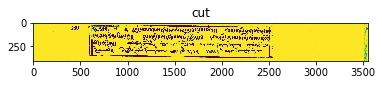

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00076-4.jpg !!!
00105.jpg
(3571, 2646)
Processing image00105


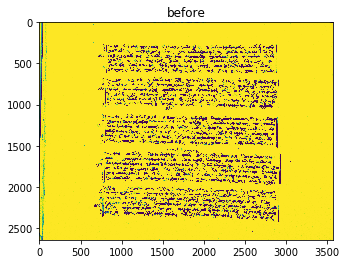

{1: 47, 2: 38, 3: 24, 4: 18}
threshold 4.572357981593145
[0, 274, 3571, 620]
[0, 675, 3571, 1049]
[0, 1126, 3571, 1492]
[0, 1576, 3571, 1968]
[0, 1998, 3571, 2407]
[0, 111.0, 3571, 661.0]


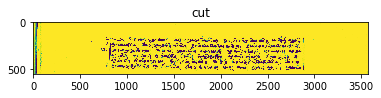

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00105-0.jpg !!!
[0, 634.0, 3571, 1090.0]


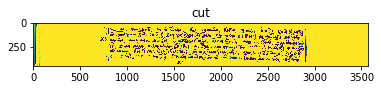

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00105-1.jpg !!!
[0, 1085.0, 3571, 1533.0]


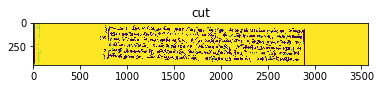

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00105-2.jpg !!!
[0, 1535.0, 3571, 2009.0]


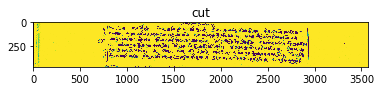

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00105-3.jpg !!!
[0, 1957.0, 3571, 2448.0]


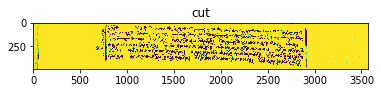

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00105-4.jpg !!!
00120.jpg
(3536, 2640)
Processing image00120


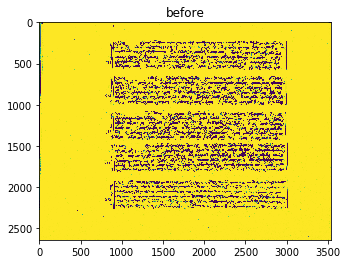

{1: 14, 2: 15, 3: 14, 4: 8}
threshold 4.50698010269576
[0, 226, 3536, 579]
[0, 649, 3536, 1006]
[0, 1081, 3536, 1434]
[0, 1465, 3536, 1811]
[0, 1915, 3536, 2263]
[0, 75.66666666666663, 3536, 625.6666666666666]


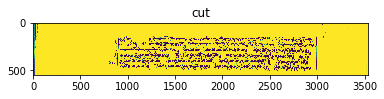

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00120-0.jpg !!!
[0, 602.3333333333334, 3536, 1052.6666666666667]


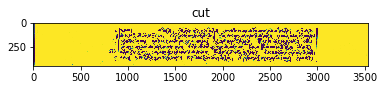

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00120-1.jpg !!!
[0, 1034.3333333333333, 3536, 1480.6666666666667]


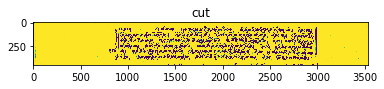

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00120-2.jpg !!!
[0, 1418.3333333333333, 3536, 1857.6666666666667]


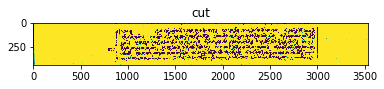

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00120-3.jpg !!!
[0, 1868.3333333333333, 3536, 2309.6666666666665]


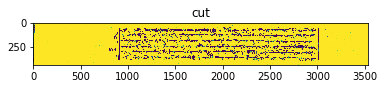

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00120-4.jpg !!!
00121.jpg
(3499, 2592)
Processing image00121


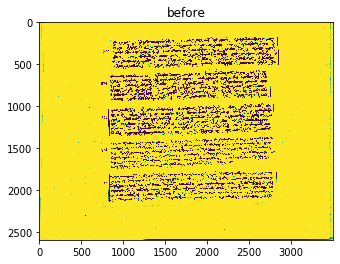

{1: 69, 2: 32, 3: 16, 4: 23}
threshold 3.5294941539460876
[0, 180, 3499, 546]
[0, 579, 3499, 939]
[0, 976, 3499, 1350]
[0, 1369, 3499, 1743]
[0, 1778, 3499, 2131]
[0, 16.66666666666663, 3499, 566.6666666666666]


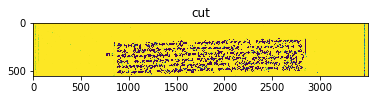

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00121-0.jpg !!!
[0, 558.3333333333334, 3499, 959.6666666666666]


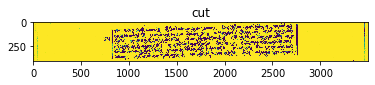

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00121-1.jpg !!!
[0, 955.3333333333334, 3499, 1370.6666666666667]


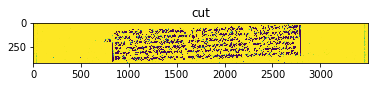

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00121-2.jpg !!!
[0, 1348.3333333333333, 3499, 1763.6666666666667]


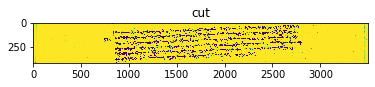

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00121-3.jpg !!!
[0, 1757.3333333333333, 3499, 2151.6666666666665]


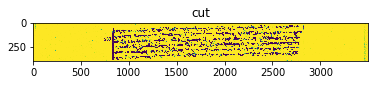

Saved Image as ../../Tibetan-Cropped/Bonpo_A_khrid_Texts/image00121-4.jpg !!!


In [65]:
threshold = 5
rows = 5
failed_list = ["00069 .jpg", "00071.jpg", "00072 .jpg", "00073.jpg", "00074.jpg", "00076.jpg", "00105.jpg", "00120.jpg", "00121.jpg"]
for image_name in failed_list:
  print(image_name)
  im = Image.open("image"+image_name)
  print(im.size)
  crop(im, "image"+image_name[:-4])